# Python建模之微分方程篇

* 解析解
* 数值解
* 传染病

![](./img/P6_1.png)

![](./img/P6_2.png)

In [3]:
# 1 微分方程解析解
import numpy as np
from scipy import integrate
import sympy

def apply_ics(sol, ics, x, known_params):
    free_params = sol.free_symbols - set(known_params)
    eqs = [(sol.lhs.diff(x, n) - sol.rhs.diff(x, n)).subs(x, 0).subs(ics) for n in range(len(ics))]
    sol_params = sympy.solve(eqs, free_params)
    return sol.subs(sol_params)

sympy.init_printing()  # 初始化打印环境
t, omega0, gamma = sympy.symbols("t, omega_0, gamma", positive=True)  # 标记参数，且均为正
x = sympy.Function('x')  # 标记x是微分函数，非变量
ode = x(t).diff(t, 2)+2*gamma*omega0*x(t).diff(t)+omega0**2*x(t)  # ode：常微分方程
ode_sol = sympy.dsolve(ode)  # 用diff()和dsolve得到通解
ics = {x(0):1, x(t).diff(t).subs(t, 0):0}  # 将初始条件字典匹配
x_t_sol = apply_ics(ode_sol, ics, t, [omega0, gamma])
sympy.pprint(x_t_sol)

                                            ⎛      _______   _______⎞         
       ⎛            γ             1⎞  -ω₀⋅t⋅⎝γ + ╲╱ γ - 1 ⋅╲╱ γ + 1 ⎠   ⎛     
x(t) = ⎜- ───────────────────── + ─⎟⋅ℯ                                + ⎜─────
       ⎜      _______   _______   2⎟                                    ⎜    _
       ⎝  2⋅╲╱ γ - 1 ⋅╲╱ γ + 1     ⎠                                    ⎝2⋅╲╱ 

                            ⎛       _______   _______⎞
     γ             1⎞  ω₀⋅t⋅⎝-γ + ╲╱ γ - 1 ⋅╲╱ γ + 1 ⎠
──────────────── + ─⎟⋅ℯ                               
______   _______   2⎟                                 
γ - 1 ⋅╲╱ γ + 1     ⎠                                 


![](./img/P6_3.png)

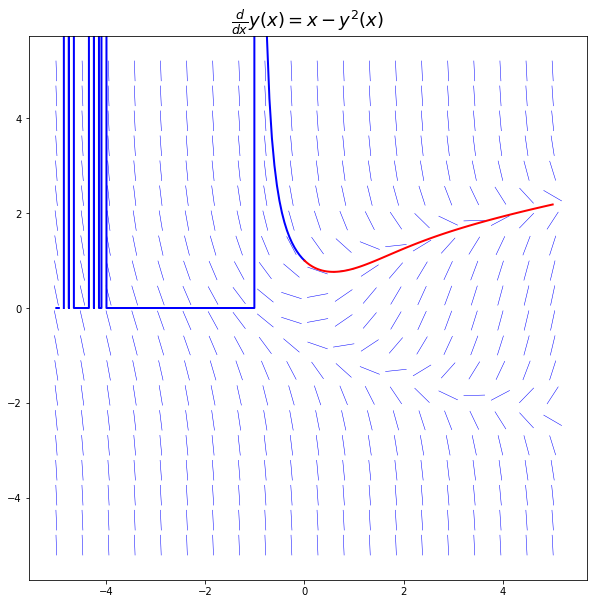

In [21]:
# 2.1 场线图与数值解
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import sympy

def plot_direction_field(x, y_x, f_xy, x_lim=(-5,5), y_lim=(-5,5), ax=None):
    f_np = sympy.lambdify((x, y_x), f_xy, 'numpy')
    x_vec = np.linspace(x_lim[0], x_lim[1], 20)
    y_vec = np.linspace(y_lim[0], y_lim[1], 20)
    if ax is None:
        _, ax = plt.subplots(figsize=(10,10))
    dx = x_vec[1] - x_vec[0]
    dy = y_vec[1] - y_vec[0]
    for m, xx in enumerate(x_vec):
        for n, yy in enumerate(y_vec):
            Dy = f_np(xx, yy) * dx
            Dx = 0.8*dx**2/np.sqrt(dx**2 + Dy**2)
            Dy = 0.8*Dy*dy/np.sqrt(dx**2 + Dy**2)
            ax.plot([xx-Dx/2, xx+Dx/2], [yy-Dy/2, yy+Dy/2], 'b', lw=0.5)
    ax.axis('tight')
    ax.set_title(r"$%s$" % (sympy.latex(sympy.Eq(y_x.diff(x), f_xy))), fontsize=18)
    return ax

x = sympy.symbols('x')
y = sympy.Function('y')
f = x-y(x)**2
f_np = sympy.lambdify((y(x),x), f)  # 符号表达式转隐函数
y0 = 1
xp = np.linspace(0,5,100)
yp = integrate.odeint(f_np, y0, xp)  # 初始y0解f_np，x范围xp
xn = np.linspace(0,-5,100)
yn = integrate.odeint(f_np, y0, xn)
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_direction_field(x, y(x), f, ax=ax)  # 绘制f的场线图
ax.plot(xn, yn, 'b', lw=2)
ax.plot(xp, yp, 'r', lw=2)
plt.show()

![](./img/P6_4.png)

D:\anaconda3\envs\swin\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  app.launch_new_instance()


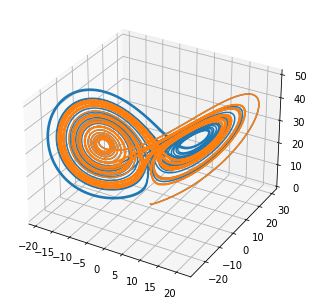

In [26]:
# 2.2 洛伦兹曲线与数值解
import numpy as np
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def dmove(Point, t, sets):
    p, r, b = sets
    x, y, z = Point
    return np.array([p*(y-x), x*(r-z), x*y-b*z])

t = np.arange(0, 30, 0.001)
P1 = odeint(dmove, (0., 1., 0.), t, args=([10., 28., 3.],))  # (0., 1., 0.)是初始点，args是超参集合
P2 = odeint(dmove, (0., 1.01, 0.), t, args=([10., 28., 3.],))

fig = plt.figure()
ax =  Axes3D(fig)
ax.plot(P1[:,0], P1[:,1], P1[:,2])
ax.plot(P2[:,0], P2[:,1], P2[:,2])
plt.show()

### 洛伦兹曲线很好地展示了非线性的直观形态，同时也是展示混沌系统的经典例子。这个例子告诉我们，混沌系统可以是一个确定系统，不一定是随机过程，同时它有初值敏感的特征。

![](./img/P6_5.png)

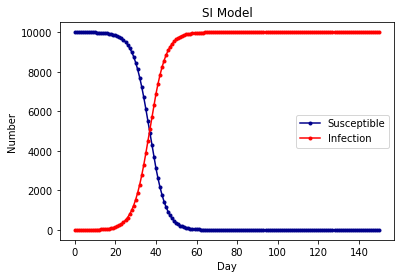

In [28]:
# 3.1 SI-Model
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

N = 10000  # N为人群总数
beta = 0.25  # beta为传染率系数
gamma = 0  # gamma为恢复率系数
I_0 = 1  # I_0为感染者的初始人数
S_0 = N-I_0  # S_0为易感染着的初始人数
T = 150  # T为传播时间
INI = (S_0, I_0)  # INI为初始状态下的数组

def funcSI(inivalue,_):
    Y = np.zeros(2)
    X = inivalue
    Y[0] = -(beta*X[0]*X[1])/N+gamma*X[1]  # 易感个体变化
    Y[1] = (beta*X[0]*X[1])/N-gamma*X[1]  # 感染个体变化
    return Y

T_range = np.arange(0, T+1)
RES = spi.odeint(funcSI, INI, T_range)
plt.plot(RES[:,0], color = 'darkblue', label = 'Susceptible', marker = '.')
plt.plot(RES[:,1], color = 'red', label = 'Infection', marker = '.')
plt.title('SI Model')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

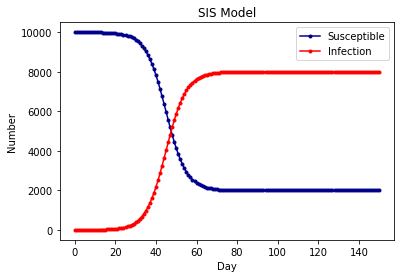

In [39]:
# 3.2 SIS-Model
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

N = 10000  # N为人群总数
beta = 0.25  # beta为传染率系数
gamma = 0.05  # gamma为恢复率系数
I_0 = 1  # I_0为感染者的初始人数
S_0 = N-I_0  # S_0为易感染着的初始人数
T = 150  # T为传播时间
INI = (S_0, I_0)  # INI为初始状态下的数组

def funcSIS(inivalue,_):
    Y = np.zeros(2)
    X = inivalue
    Y[0] = -(beta*X[0]*X[1])/N+gamma*X[1]  # 易感个体变化，与SI模型形式相同
    Y[1] = (beta*X[0]*X[1])/N-gamma*X[1]  # 感染个体变化
    return Y

T_range = np.arange(0, T+1)
RES = spi.odeint(funcSIS, INI, T_range)
plt.plot(RES[:,0], color = 'darkblue', label = 'Susceptible', marker = '.')
plt.plot(RES[:,1], color = 'red', label = 'Infection', marker = '.')
plt.title('SIS Model')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

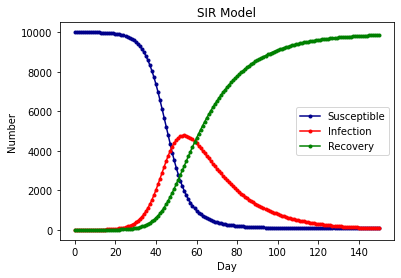

In [31]:
# 3.3 SIR-Model
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

N = 10000  # N为人群总数
beta = 0.25  # beta为传染率系数
gamma = 0.05  # gamma为恢复率系数
I_0 = 1  # I_0为感染者的初始人数
R_0 = 0  # R_0为治愈者的初始人数
S_0 = N - I_0 - R_0  # S_0为易感染着的初始人数
T = 150  # T为传播时间
INI = (S_0, I_0, R_0)  # INI为初始状态下的数组

def funcSIR(inivalue,_):
    Y = np.zeros(3)
    X = inivalue
    Y[0] = -(beta*X[0]*X[1])/N  # 易感个体变化，与SI模型不同
    Y[1] = (beta*X[0]*X[1])/N-gamma*X[1]  # 感染个体变化
    Y[2] = gamma*X[1]  # 治愈个体变化
    return Y

T_range = np.arange(0, T+1)
RES = spi.odeint(funcSIR, INI, T_range)
plt.plot(RES[:,0], color = 'darkblue', label = 'Susceptible', marker = '.')
plt.plot(RES[:,1], color = 'red', label = 'Infection', marker = '.')
plt.plot(RES[:,2], color = 'green', label = 'Recovery', marker = '.')
plt.title('SIR Model')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

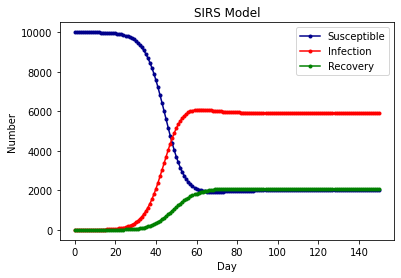

In [35]:
# 3.4 SIRS-Model 抗体有时效
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

N = 10000  # N为人群总数
beta = 0.25  # beta为传染率系数
gamma = 0.05  # gamma为恢复率系数

Ts = 7  # Ts为抗体持续时间

I_0 = 1  # I_0为感染者的初始人数
R_0 = 0  # R_0为治愈者的初始人数
S_0 = N - I_0 - R_0  # S_0为易感染着的初始人数
T = 150  # T为传播时间
INI = (S_0, I_0, R_0)  # INI为初始状态下的数组

def funcSIRS(inivalue,_):
    Y = np.zeros(3)
    X = inivalue
    Y[0] = -(beta*X[0]*X[1])/N+X[2]/Ts  # 易感个体变化，与SI模型不同
    Y[1] = (beta*X[0]*X[1])/N-gamma*X[1]  # 感染个体变化
    Y[2] = gamma*X[1]-X[2]/Ts  # 治愈个体变化
    return Y

T_range = np.arange(0, T+1)
RES = spi.odeint(funcSIRS, INI, T_range)
plt.plot(RES[:,0], color = 'darkblue', label = 'Susceptible', marker = '.')
plt.plot(RES[:,1], color = 'red', label = 'Infection', marker = '.')
plt.plot(RES[:,2], color = 'green', label = 'Recovery', marker = '.')
plt.title('SIRS Model')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

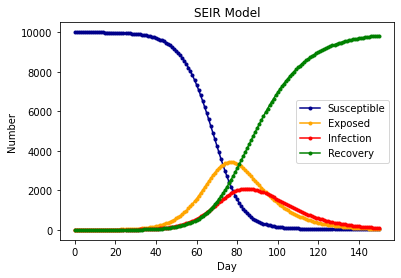

In [37]:
# 3.5 SEIR-Model 有潜伏期
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

N = 10000  # N为人群总数
beta = 0.6  # beta为传染率系数
gamma = 0.1  # gamma为恢复率系数

Te = 14  # Te为疾病潜伏期

I_0 = 1  # I_0为感染者的初始人数
E_0 = 0  # E_0为潜伏着的初始人数
R_0 = 0  # R_0为治愈者的初始人数
S_0 = N - I_0 - R_0 - E_0  # S_0为易感染着的初始人数
T = 150  # T为传播时间
INI = (S_0, E_0, I_0, R_0)  # INI为初始状态下的数组

def funcSEIR(inivalue,_):
    Y = np.zeros(4)
    X = inivalue
    Y[0] = -(beta*X[0]*X[2])/N  # 易感个体变化
    Y[1] = (beta*X[0]*X[2])/N-X[1]/Te  # 潜伏个体变化
    Y[2] = X[1]/Te-gamma*X[2]  # 感染个体变化
    Y[3] = gamma*X[2]  # 治愈个体变化
    return Y

T_range = np.arange(0, T+1)
RES = spi.odeint(funcSEIR, INI, T_range)
plt.plot(RES[:,0], color = 'darkblue', label = 'Susceptible', marker = '.')
plt.plot(RES[:,1], color = 'orange', label = 'Exposed', marker = '.')
plt.plot(RES[:,2], color = 'red', label = 'Infection', marker = '.')
plt.plot(RES[:,3], color = 'green', label = 'Recovery', marker = '.')
plt.title('SEIR Model')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

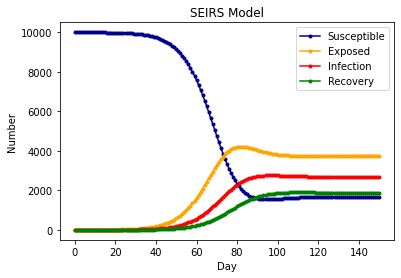

In [38]:
# 3.6 SEIRS-Model 有潜伏期,抗体持续时间
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

N = 10000  # N为人群总数
beta = 0.6  # beta为传染率系数
gamma = 0.1  # gamma为恢复率系数

Ts = 7  # Ts为抗体持续时间
Te = 14  # Te为疾病潜伏期

I_0 = 1  # I_0为感染者的初始人数
E_0 = 0  # E_0为潜伏着的初始人数
R_0 = 0  # R_0为治愈者的初始人数
S_0 = N - I_0 - R_0 - E_0  # S_0为易感染着的初始人数
T = 150  # T为传播时间
INI = (S_0, E_0, I_0, R_0)  # INI为初始状态下的数组

def funcSEIRS(inivalue,_):
    Y = np.zeros(4)
    X = inivalue
    Y[0] = -(beta*X[0]*X[2])/N+X[3]/Ts  # 易感个体变化
    Y[1] = (beta*X[0]*X[2])/N-X[1]/Te  # 潜伏个体变化
    Y[2] = X[1]/Te-gamma*X[2]  # 感染个体变化
    Y[3] = gamma*X[2]-X[3]/Ts  # 治愈个体变化
    return Y

T_range = np.arange(0, T+1)
RES = spi.odeint(funcSEIRS, INI, T_range)
plt.plot(RES[:,0], color = 'darkblue', label = 'Susceptible', marker = '.')
plt.plot(RES[:,1], color = 'orange', label = 'Exposed', marker = '.')
plt.plot(RES[:,2], color = 'red', label = 'Infection', marker = '.')
plt.plot(RES[:,3], color = 'green', label = 'Recovery', marker = '.')
plt.title('SEIRS Model')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()